# Simpsons Characters Recognition
## Definition and training of the neuronal network
I will implement a resnet 34. For the sake of learning I will not use a pretrained but follow the implementation shown by Aurélien Géron in chapter 14 of his book _"Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow"_ (https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)<br>
Notebooks consist of the following:
- Loading settings
- Splitting list of images into train, test and validation images
- Definition of the model
- Training the model
- Evaluation of the model with the testset

In [17]:
#Import libaries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys

#Scikit-Learn und Models
from sklearn.model_selection import train_test_split

#Keras
import tensorflow as tf
from tensorflow import keras

In [18]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#make folders in google colab and copy files
!mkdir '/content/data/'
!cp '/content/drive/MyDrive/Colab Notebooks/simpsons_dataset.zip' '/content/data/simpsons_dataset.zip'
!cp '/content/drive/MyDrive/Colab Notebooks/simpsons_testset.zip' '/content/data/simpsons_testset.zip'
!cp '/content/drive/MyDrive/Colab Notebooks/simpsons_keras_model.h5' '/content/data/simpsons_keras_model.h5'
!cp '/content/drive/MyDrive/Colab Notebooks/settings_dict.json' '/content/data/settings_dict.json'
!cp '/content/drive/MyDrive/Colab Notebooks/char_list_reduced.json' '/content/data/char_list_reduced.json'

mkdir: cannot create directory ‘/content/data/’: File exists


In [20]:
#Unzip data
!unzip -n '/content/data/simpsons_dataset.zip' -d '/content/data/' 
!unzip -n '/content/data/simpsons_testset.zip' -d '/content/data/'

Archive:  /content/data/simpsons_dataset.zip
Archive:  /content/data/simpsons_testset.zip


In [21]:
#copy pyfiles for custom functions
!cp '/content/drive/MyDrive/Colab Notebooks/simpsons_utils.py' '/content/simpsons_utils.py'
!cp '/content/drive/MyDrive/Colab Notebooks/resnet34.py' '/content/resnet34.py'

In [22]:
#import custom functions
sys.path.insert(0,'/content/')

import simpsons_utils as su
import resnet34

### Settings and loading settings

In [23]:
#Settings
path = '/content/data/'
train_path = '/content/data/simpsons_dataset/'
test_path = '/content/data/simpsons_testset/'

#chunk_size used so not all data needs to be read at once 
chunk_size = 16384

#Load dict with settings for image correction
with open(f'{path}settings_dict.json',) as file:
    settings_dict = json.load(file)

#Load list of characters
with open(f'{path}char_list_reduced.json',)  as file:
    character_list = json.load(file)

### Splitting the image list
I split the list of training images further into chunks. So not all images need to be loaded into memory at the same time

In [24]:
#Read path and names to all image files
image_files, labels = su.create_train_image_list(train_path, character_list)

#Split data into train and test, split train into train and validate 
X_train, X_test, y_train, y_test = train_test_split(image_files,
                                          labels,
                                          train_size=0.8,
                                          stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  train_size=0.8,
                                                  stratify=y_train)

In [25]:
#Length of all datasets
print(f"Images in Trainset:\t{X_train.shape}\nImages in Validationset:{X_val.shape}\nImages in Testset\t{X_test.shape}")

Images in Trainset:	(12510,)
Images in Validationset:(3128,)
Images in Testset	(3910,)


In [26]:
#split image list of train images into chunks
X_train_chunks, y_train_chunks = su.make_chunks(X_train, y_train, chunk_size)

### Model Definiton
- Declare a residual layer class which will be by the model
- Declare function for model definition
- Create model

In [27]:
#setup GPU
#tf.device(tf.test.gpu_device_name())

model = resnet34.resnet34(settings_dict)

#compile model, needed before usage
model.compile(loss='sparse_categorical_crossentropy'
              , optimizer=keras.optimizers.Adam()
              , metrics=['accuracy'])

#print summary of model and save model defintion to file
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 64)        9408      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
residual_unit_16 (ResidualUn (None, 16, 16, 64)        74240     
_________________________________________________________________
residual_unit_17 (ResidualUn (None, 16, 16, 64)        74240     
_________________________________________________________________
residual_unit_18 (ResidualUn (None, 16, 16, 64)       

### Training of the model
- Load old weights if available

In [28]:
#Load model if exists
try:
    model.load_weights(f'{path}/simpsons_keras_model.h5')
except:
    print('Weights file does not exist')

In [29]:
#Train Model
#model will be trained in several chunks of data rather than in one go

#callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("simpsons_keras_model.h5", save_best_only=True)

#Train Model. Load only batches of the train and validate data. Train same data on multiple validate data
no_chunks = len(X_train_chunks)

X_val_images = su.load_transform_images(X_val, settings_dict)
#Load batches of images an train
for idn, (X_train_chunk, y_train_chunk) in enumerate(zip(X_train_chunks, y_train_chunks)):
    print(f"Chunk: {idn + 1}/{no_chunks}")
    X_train_images = su.load_transform_images(X_train_chunk, settings_dict)
    #train
    history = model.fit(X_train_images, y_train_chunk, epochs=100
                        , validation_data=(X_val_images, y_val)
                        , callbacks=[early_stopping_cb]
                           )
    #save model weights
    model.save_weights(f'{path}/simpsons_keras_model.h5')

Chunk: 1/1
Epoch 1/100
391/391 [==============================] - 20s 44ms/step - loss: 0.2271 - accuracy: 0.9449 - val_loss: 0.2512 - val_accuracy: 0.9252
Epoch 2/100
391/391 [==============================] - 16s 42ms/step - loss: 0.0935 - accuracy: 0.9736 - val_loss: 0.6535 - val_accuracy: 0.8366
Epoch 3/100
391/391 [==============================] - 17s 42ms/step - loss: 0.1088 - accuracy: 0.9712 - val_loss: 0.5356 - val_accuracy: 0.8664
Epoch 4/100
391/391 [==============================] - 17s 42ms/step - loss: 0.0987 - accuracy: 0.9755 - val_loss: 0.2507 - val_accuracy: 0.9351
Epoch 5/100
391/391 [==============================] - 17s 43ms/step - loss: 0.1184 - accuracy: 0.9699 - val_loss: 0.3744 - val_accuracy: 0.9063
Epoch 6/100
391/391 [==============================] - 17s 43ms/step - loss: 0.0763 - accuracy: 0.9766 - val_loss: 0.1837 - val_accuracy: 0.9508
Epoch 7/100
391/391 [==============================] - 17s 43ms/step - loss: 0.0288 - accuracy: 0.9931 - val_loss: 0.17

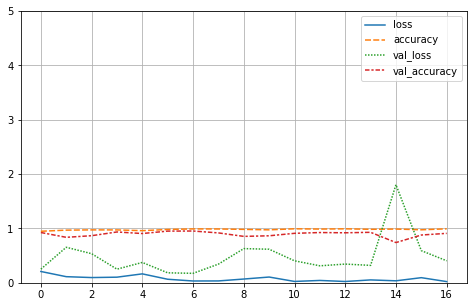

In [30]:
#Plot history of training
df_hist = history.history
plt.figure(figsize=(8, 5))
plt.grid(True)
acc_plot = sns.lineplot(data=df_hist)
acc_plot.set_ylim(0, 5);

In [31]:
#Evaluate on Testset
X_test_images = su.load_transform_images(X_test, settings_dict)
model.evaluate(X_test_images, y_test)

123/123 [==============================] - 2s 12ms/step - loss: 0.2092 - accuracy: 0.9501


[0.20922136306762695, 0.950127899646759]

Accuracy of 95% is not bad of for a model with no further tuning of the hyperparameters

In [33]:
#copy weights back to google drive
!cp '/content/data/simpsons_keras_model.h5' '/content/drive/MyDrive/Colab Notebooks/simpsons_keras_model.h5'